# Single Cell Sequencing 


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>
Performs quality control separately for each plate.<br>

In [39]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
import pyreadr
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
import config as general_paths
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [40]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path

In [41]:
# Filtering parameters

HOW_MANY_HIGHLY_VARIABLE_GENES = 16000 # it used to be 15000 (but that cuts out Piezo1 after filtering out not highly variable genes)
MIN_CELL_COUNTS = 10000
MIN_GENES = 3000
MIN_CELLS_WITH_GENE = 5
MITOCHONDRIAL_THRESHOLD_PCT = 5

In [42]:
# campari_file = 'campari_scs_from_R.h5ad'
# campari_file_all_genes = 'campari_scs_all_genes_from_R.h5ad'

# h5ad files with scs data
results_file_sample1 = os.path.join(local_path, "sample1/counts_umi/sample1_R.h5ad")
results_file_sample2 = os.path.join(local_path, "sample2/counts_umi/sample2_R.h5ad")
results_file_sample3 = os.path.join(local_path, "sample3/counts_umi/sample3_R.h5ad") 
results_file_sample4 = os.path.join(local_path, "sample4/counts_umi/sample4_R.h5ad")
results_file_sample5 = os.path.join(local_path, "sample5/counts_umi/sample5_R.h5ad")
results_file_sample6 = os.path.join(local_path, "sample6/counts_umi/sample6_R.h5ad")
results_file_sample7 = os.path.join(local_path, "sample7/counts_umi/sample7_R.h5ad")

# txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = os.path.join(local_path, "sample1/counts_umi/SS3_22_291.well_barcodes.txt")
well_barcode_sample2 = os.path.join(local_path, "sample2/counts_umi/SS3_23_049.well_barcodes.txt")
well_barcode_sample3 = os.path.join(local_path, "sample3/counts_umi/SS3_23_127.well_barcodes.txt")
well_barcode_sample4 = os.path.join(local_path, "sample4/counts_umi/SS3_23_193.well_barcodes.txt")
well_barcode_sample5 = os.path.join(local_path, "sample5/counts_umi/SS3_23_195.well_barcodes.txt")
well_barcode_sample6 = os.path.join(local_path, "sample6/counts_umi/SS3_23_325.well_barcodes.txt")
well_barcode_sample7 = os.path.join(local_path, "sample7/counts_umi/SS3_23_327.well_barcodes.txt")

# upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = os.path.join(local_path, "sample1/counts_umi/well_1_data_base.csv")
florecence_2_file_path = os.path.join(local_path, "sample2/counts_umi/well_2_data_base.csv")
florecence_3_file_path = os.path.join(local_path, "sample3/counts_umi/well_3_data_base.csv")
florecence_4_file_path = os.path.join(local_path, "sample4/counts_umi/well_4_data_base.csv")
florecence_5_file_path = os.path.join(local_path, "sample5/counts_umi/well_5_data_base.csv")
florecence_6_file_path = os.path.join(local_path, "sample6/counts_umi/well_6_data_base.csv")
florecence_7_file_path = os.path.join(local_path, "sample7/counts_umi/well_7_data_base.csv")

# paths to files with a list of gene ids and matching gene names (they are not the same the same for each plate!)
genes1_path = os.path.join(local_path, "sample1/counts_umi/SS3_22_291.gene_names.txt")
genes2_path = os.path.join(local_path, "sample2/counts_umi/SS3_23_049.gene_names.txt")
genes3_path = os.path.join(local_path, "sample3/counts_umi/SS3_23_127.gene_names.txt")
genes4_path = os.path.join(local_path, "sample4/counts_umi/SS3_23_193.gene_names.txt")
genes5_path = os.path.join(local_path, "sample5/counts_umi/SS3_23_195.gene_names.txt")
genes6_path = os.path.join(local_path, "sample6/counts_umi/SS3_23_325.gene_names.txt")
genes7_path = os.path.join(local_path, "sample7/counts_umi/SS3_23_327.gene_names.txt")

In [44]:
# load adata file using adata library
adata1 = ad.read_h5ad(results_file_sample1)
adata2 = ad.read_h5ad(results_file_sample2)
adata3 = ad.read_h5ad(results_file_sample3)
adata3 = ad.read_h5ad(results_file_sample3)
adata4 = ad.read_h5ad(results_file_sample4)
adata5 = ad.read_h5ad(results_file_sample5)
adata6 = ad.read_h5ad(results_file_sample6)
adata7 = ad.read_h5ad(results_file_sample7)

# read gene ids and names
genes1 = pd.read_csv(genes1_path, delimiter = "\t")
genes2 =  pd.read_csv(genes2_path, delimiter = "\t")
genes3 =  pd.read_csv(genes3_path, delimiter = "\t")
genes4 =  pd.read_csv(genes4_path, delimiter = "\t")
genes5 =  pd.read_csv(genes5_path, delimiter = "\t")
genes6 =  pd.read_csv(genes6_path, delimiter = "\t")
genes7 =  pd.read_csv(genes7_path, delimiter = "\t")

# read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)
flourecence6 = pd.read_csv(florecence_6_file_path)
flourecence7 = pd.read_csv(florecence_7_file_path)

# read barcodes in the same order as in the anndata object
barcodes1 = [el[0] for el in list(adata1.obs.values)]
barcodes2 = [el[0] for el in list(adata2.obs.values)]
barcodes3 = [el[0] for el in list(adata3.obs.values)]
barcodes4 = [el[0] for el in list(adata4.obs.values)]
barcodes5 = [el[0] for el in list(adata5.obs.values)]
barcodes6 = [el[0] for el in list(adata6.obs.values)]
barcodes7 = [el[0] for el in list(adata7.obs.values)]



In [45]:
# merge data base. Merge information about cell barcode and fluorecence 
#(using as common demonimator the position in the plate)
# barcode_list_sample1 = list(df_1_sample1['XC']) # from kept barcodes
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

# barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

# barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

well_df_sample4 = pd.read_csv(well_barcode_sample4, delimiter = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

well_df_sample5 = pd.read_csv(well_barcode_sample5, delimiter = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

well_df_sample6 = pd.read_csv(well_barcode_sample6, delimiter = "\t")
mergedRes6 = pd.merge(well_df_sample6 , flourecence6, on ='well_id')

well_df_sample7 = pd.read_csv(well_barcode_sample7, delimiter = "\t")
mergedRes7 = pd.merge(well_df_sample7 , flourecence7, on ='well_id')

In [46]:
# Perform quality control separately for all samples
sample1 = adata1
sample2 = adata2
sample3 = adata3
sample4 = adata4
sample5 = adata5
sample6 = adata6
sample7 = adata7

In [47]:
# make names unique
sample1.var_names_make_unique()
sample2.var_names_make_unique()
sample3.var_names_make_unique()
sample4.var_names_make_unique()
sample5.var_names_make_unique()
sample6.var_names_make_unique()
sample7.var_names_make_unique()

In [48]:
#Create a plot showing genes detected as a function of UMI counts.
def plot_counts(adata,plot_title):
    fig, ax = plt.subplots(1,3)
    x = np.asarray(adata.X.sum(axis=1))
    y = np.asarray(np.sum(adata.X>0, axis=1))
    ax[0].scatter(x, y, color="b", alpha=0.25)
    ax[0].set_ylabel("Genes Detected")
    ax[0].set_xlabel("UMI Counts")
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    #histogram definition
    bins = [1500, 1500] # number of bins
    # histogram the data
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]

    s = ax[1].scatter(x2, y2, c=z2, cmap='viridis_r')  
    fig.colorbar(s, ax=ax)

    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel("UMI Counts")
    ax[1].set_ylabel("Genes Detected")


    expected_num_cells =  380#@param {type:"integer"}
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

    ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
    ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
    ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

    ax[2].set_xlabel("UMI Counts")
    ax[2].set_ylabel("Set of Barcodes")

    #plt.grid(True, which="both")
    fig.suptitle(plot_title, fontsize=16)

    fig.set_size_inches([20,3])
    plt.show()
# fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))

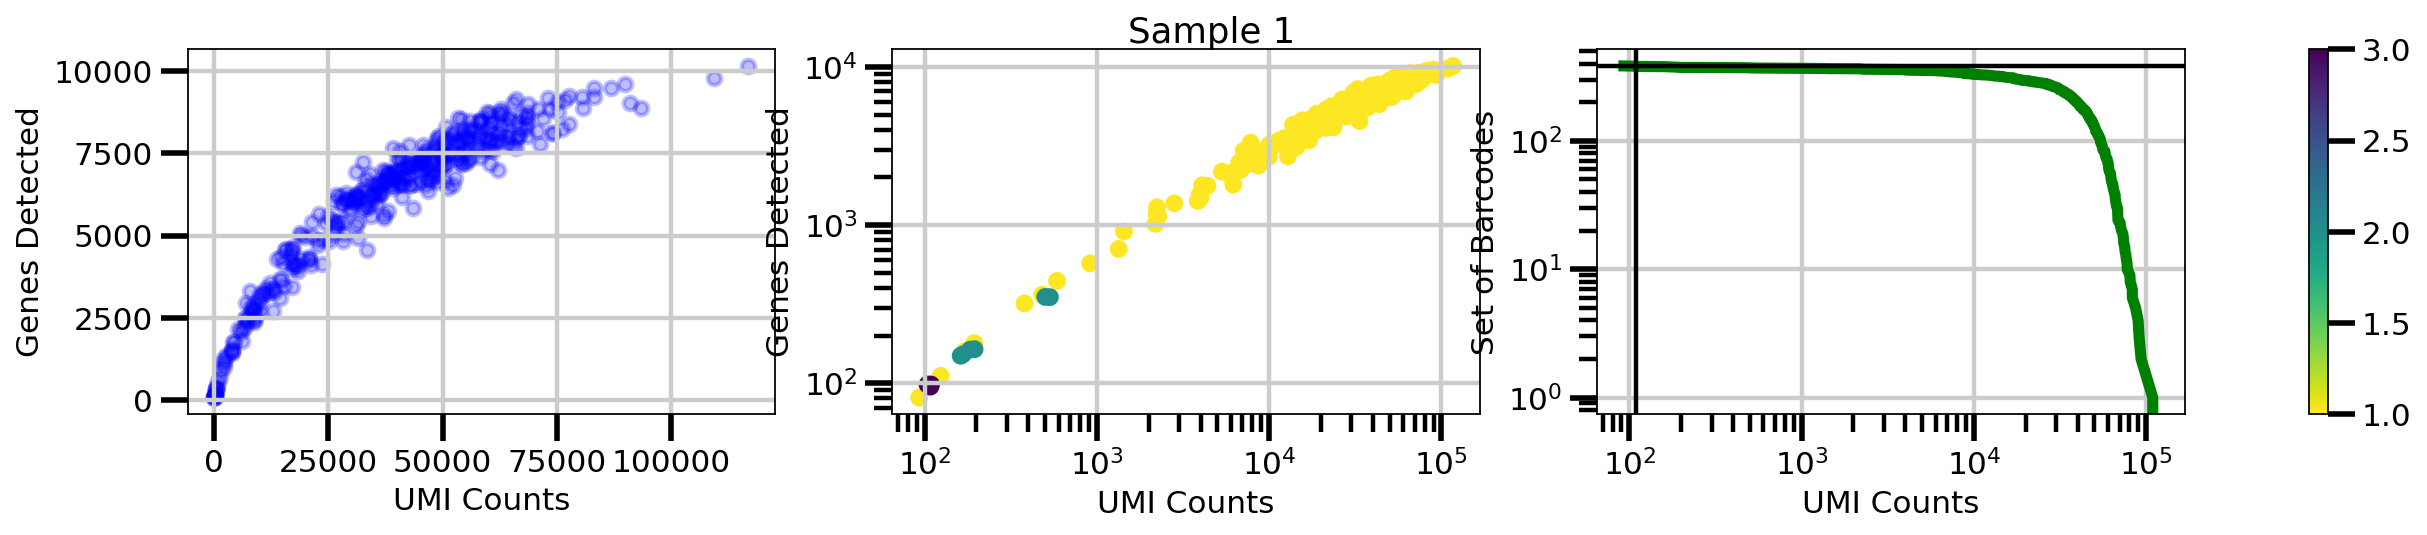

In [49]:
plot_counts(sample1,"Sample 1")

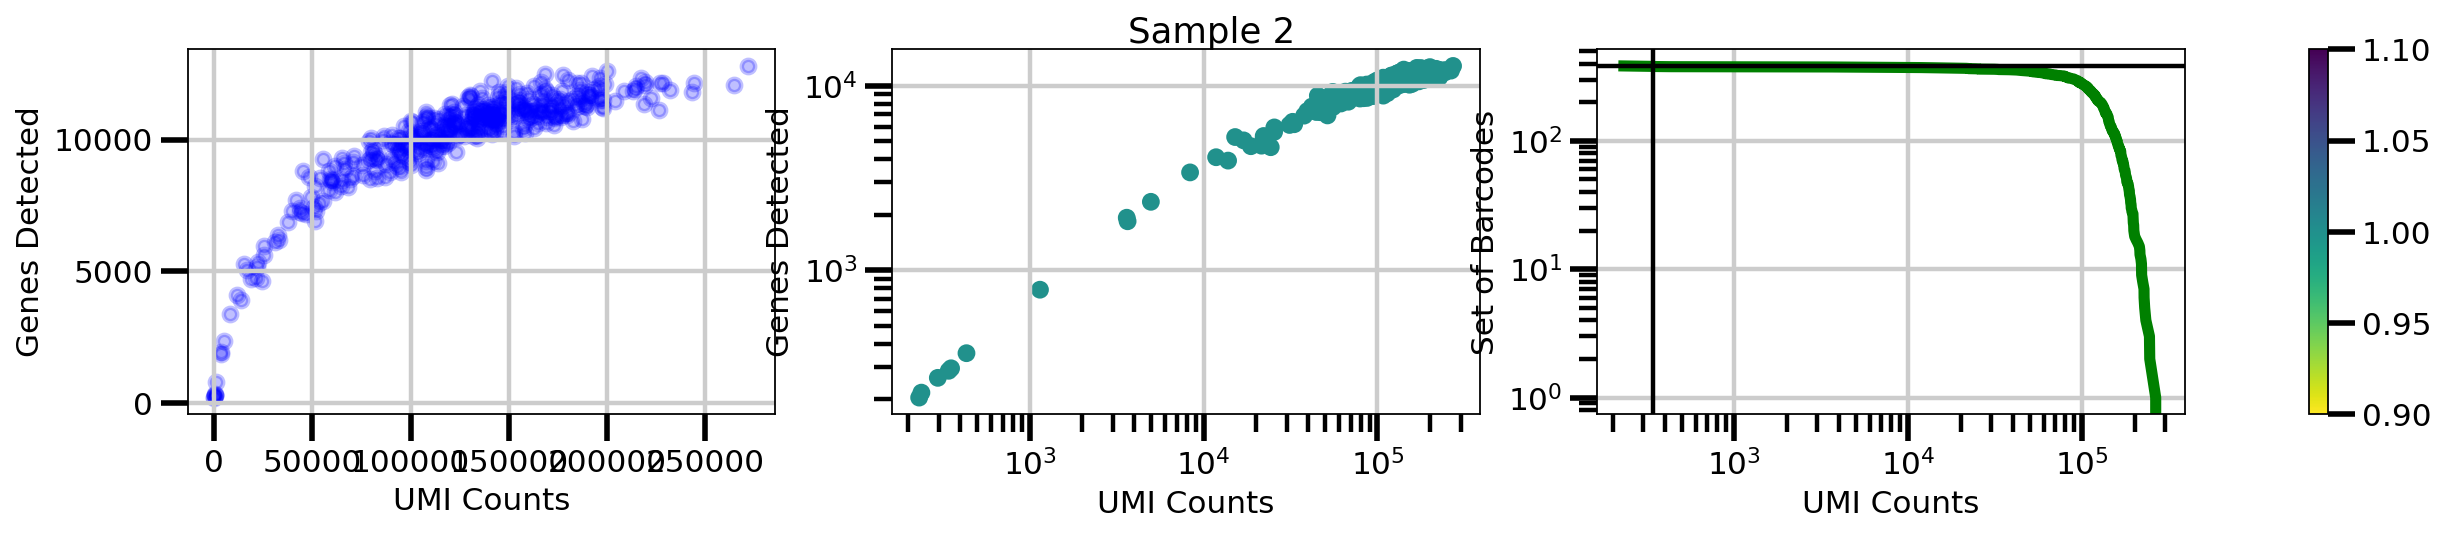

In [50]:
plot_counts(sample2,"Sample 2")

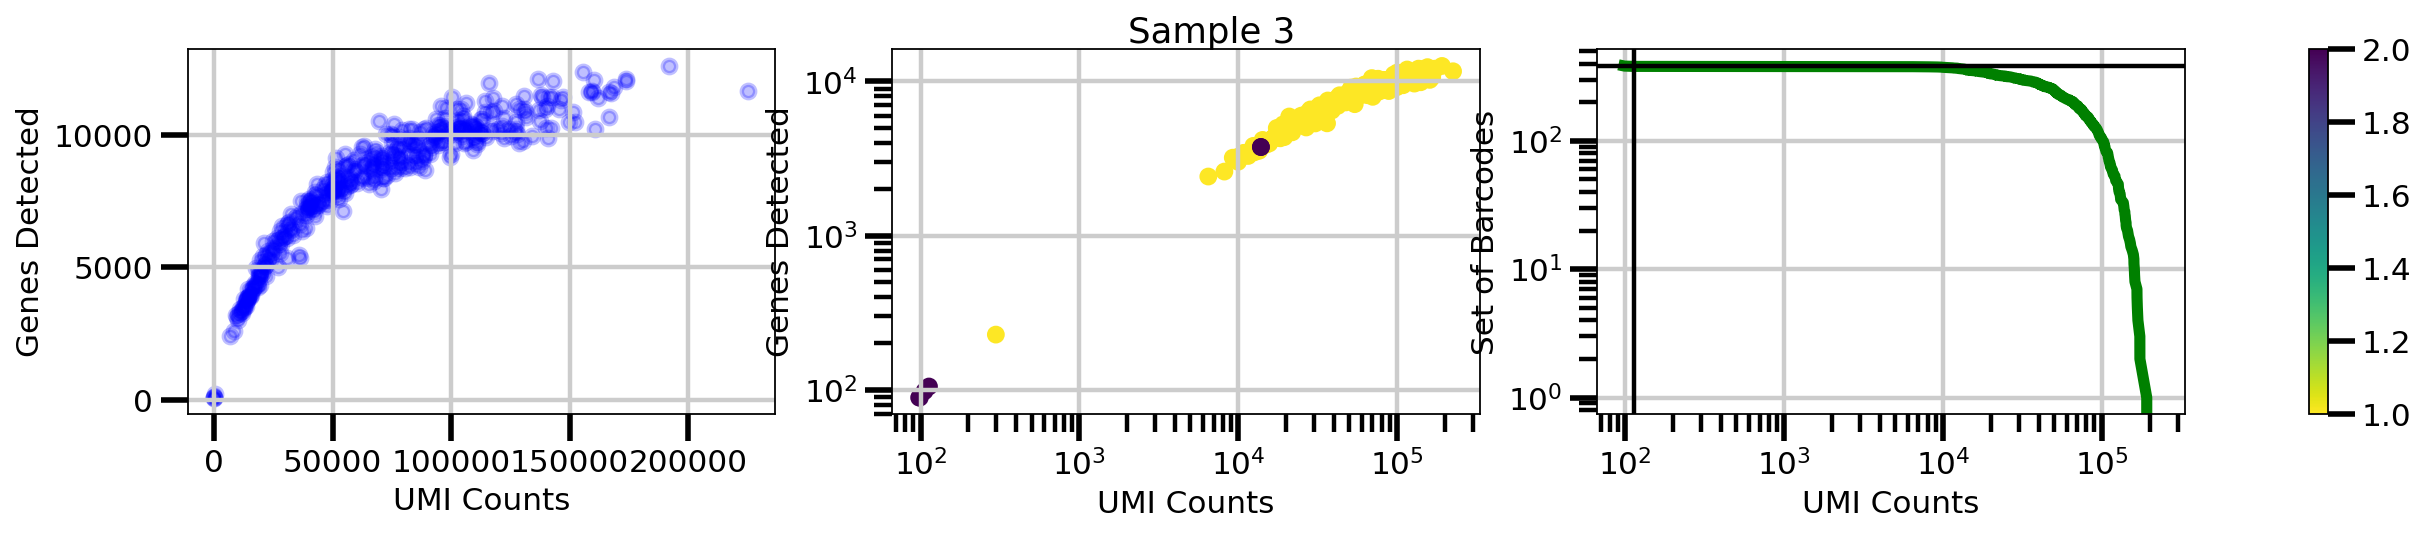

In [51]:
plot_counts(sample3,"Sample 3")

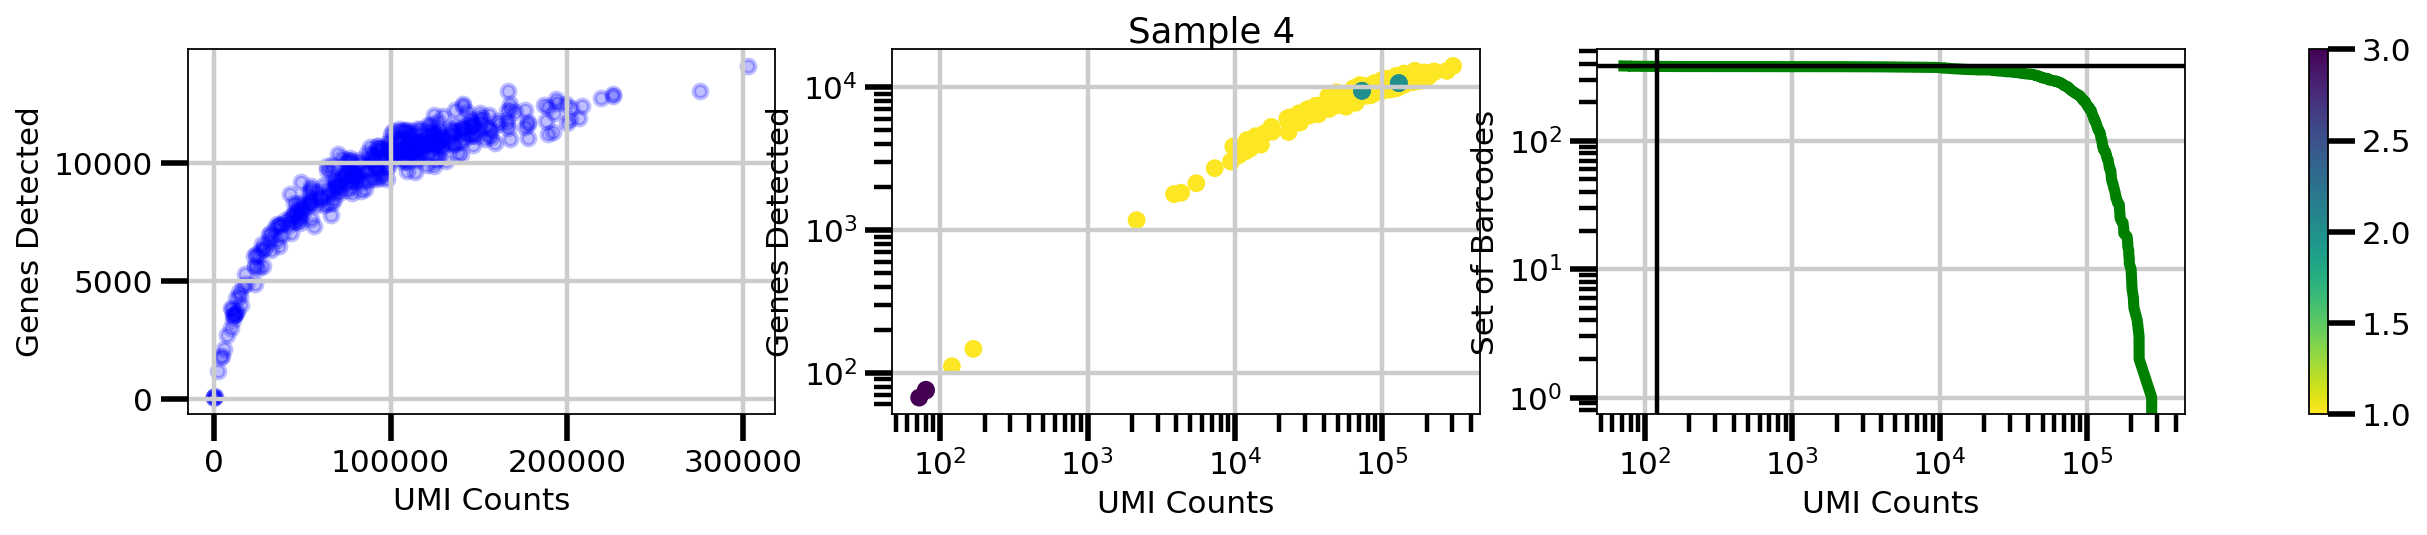

In [52]:
plot_counts(sample4,"Sample 4")

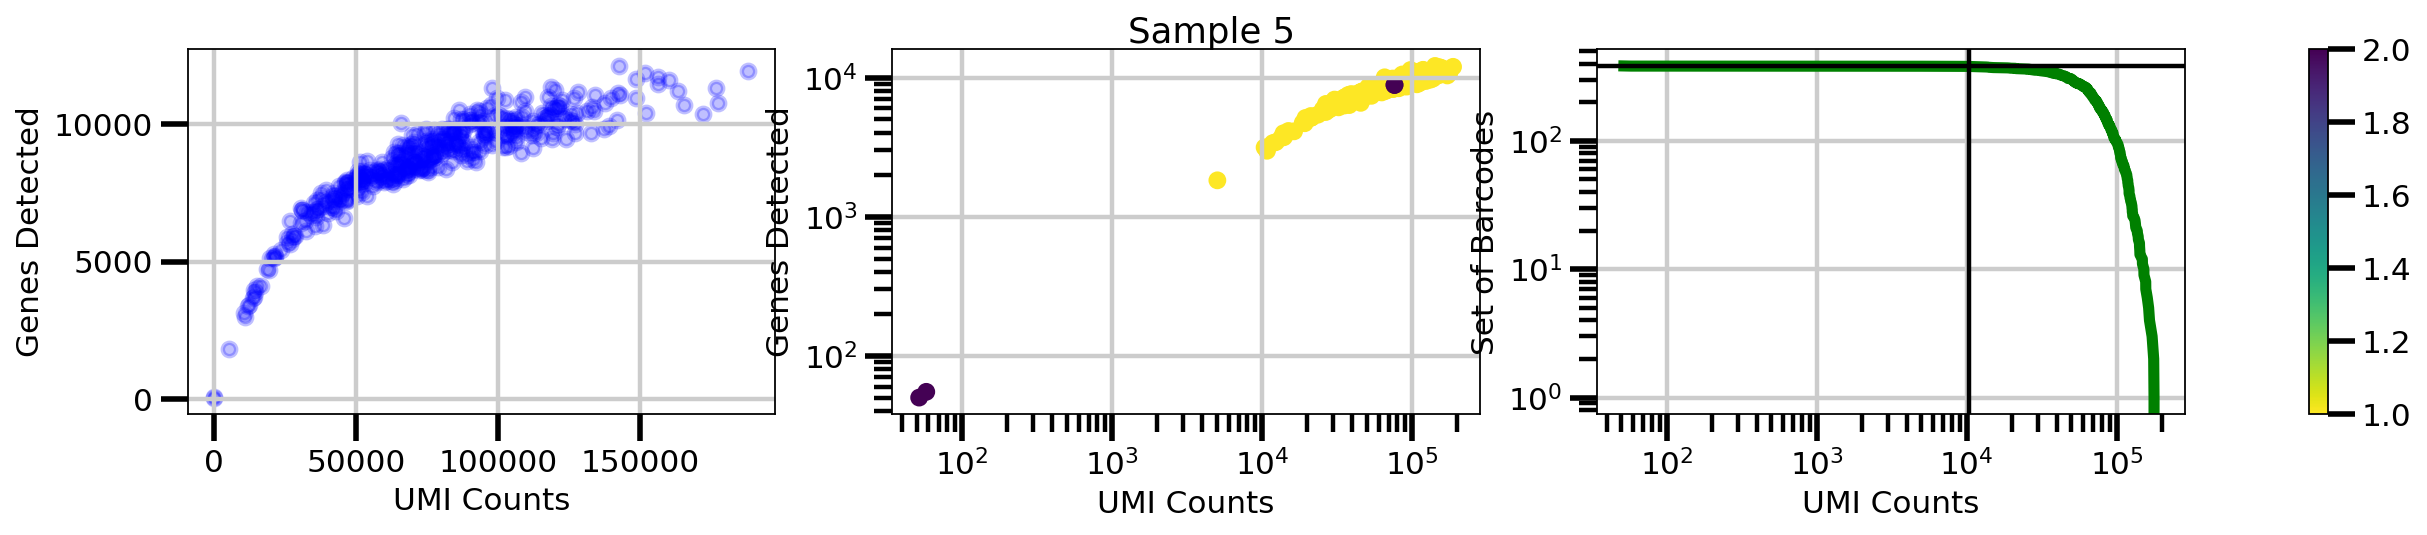

In [53]:
plot_counts(sample5,"Sample 5")

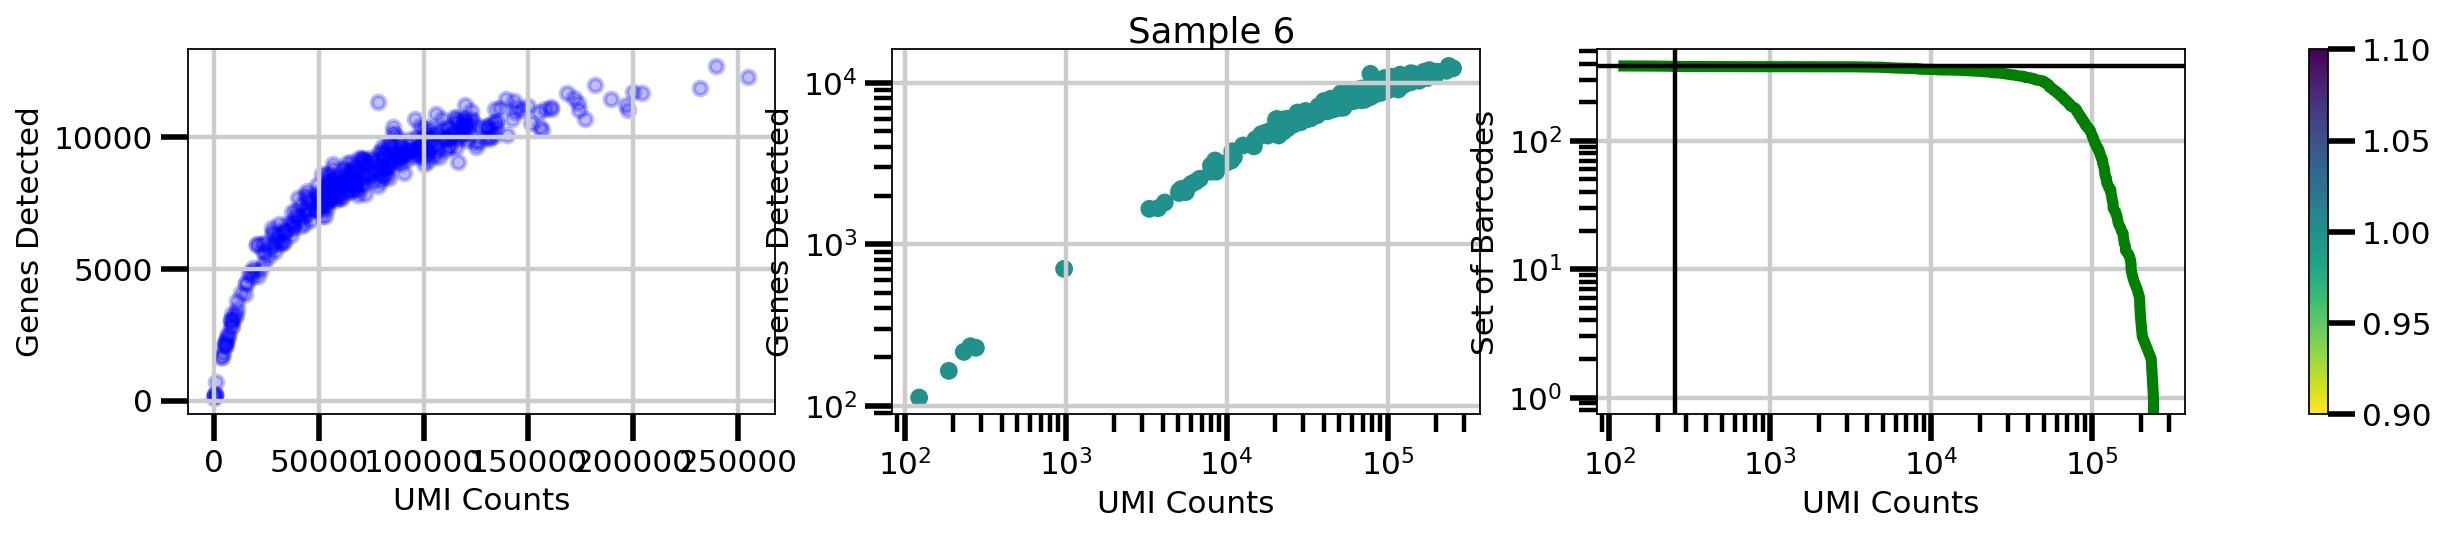

In [54]:
plot_counts(sample6,"Sample 6")

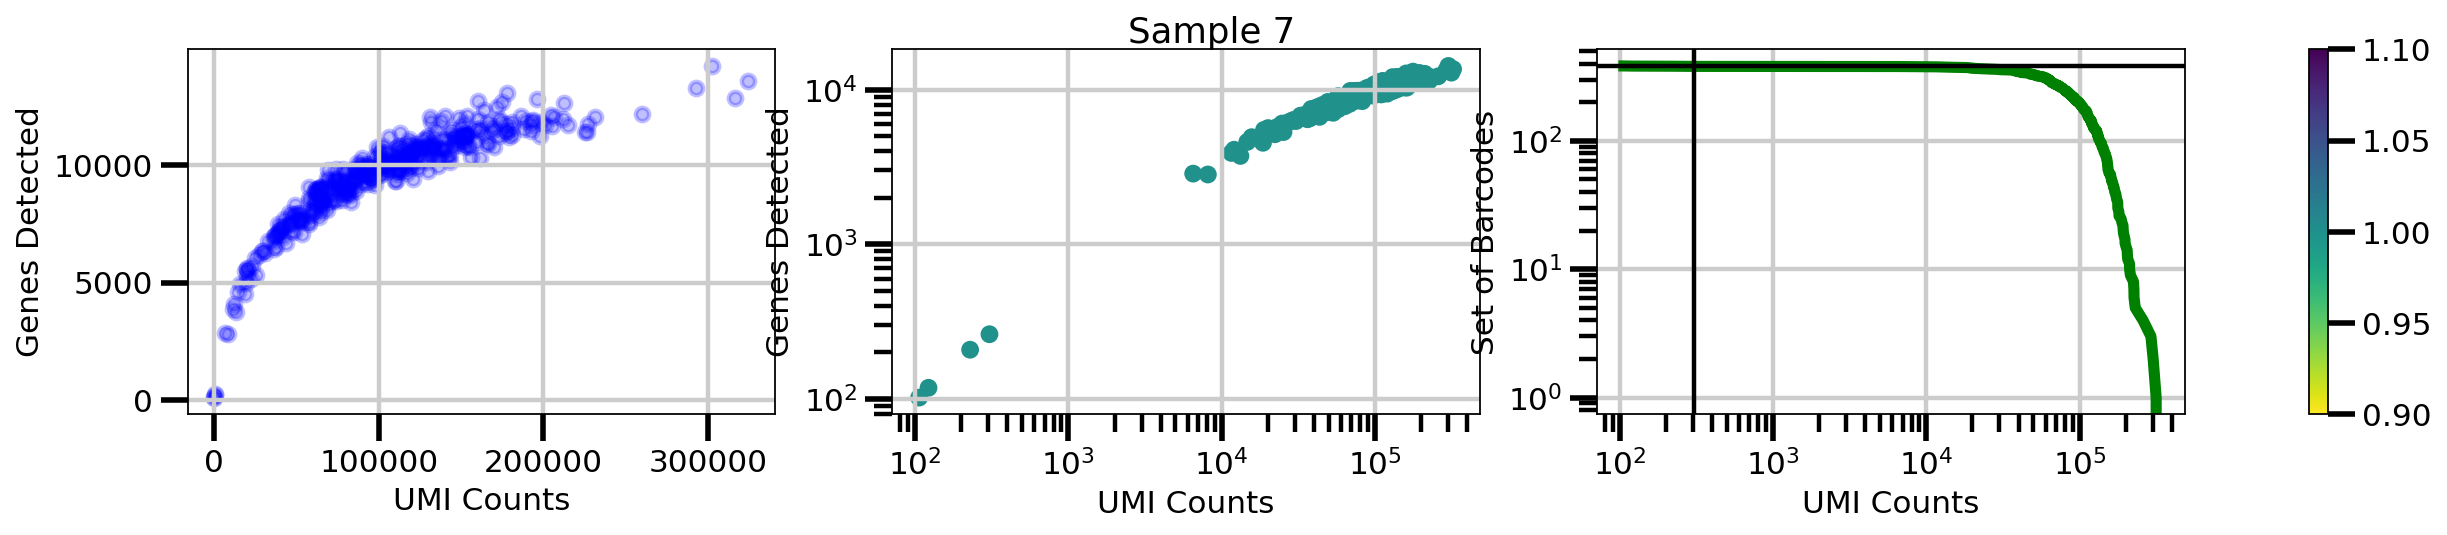

In [55]:
plot_counts(sample7,"Sample 7")

In [56]:
# takes list of gene ids and list of dataframes with id2names, returns list of matched gene names
# gene ids come from all plates now, and each plate has own file with gene names
def translate2gene_names(gene_ids,list_of_gene_files):
    cnt= 0
    gene_names = []
    for i,id in enumerate(gene_ids):
        gene = id
        for gene_list in list_of_gene_files:
            ids = gene_list["gene_id"].tolist()
            names = gene_list["gene_name"].tolist()
            if id in ids:
                idx = ids.index(id)
                gene = names[idx]
        # if after searching in all available gene files, id still not translated to name
        # use gene id as gene name
        if gene == id:
            cnt+=1
        gene_names.append(gene)
    if cnt >0:
        print(f"missing {cnt} gene names")
    return gene_names

In [57]:
# translate gene ids to names and add to anndata
gene_names1 = translate2gene_names(sample1.var["gene_id"].values,[genes1])
gene_names2 = translate2gene_names(sample2.var["gene_id"].values,[genes2])
gene_names3 = translate2gene_names(sample3.var["gene_id"].values,[genes3])
gene_names4 = translate2gene_names(sample4.var["gene_id"].values,[genes4])
gene_names5 = translate2gene_names(sample5.var["gene_id"].values,[genes5])
gene_names6 = translate2gene_names(sample6.var["gene_id"].values,[genes6])
gene_names7 = translate2gene_names(sample7.var["gene_id"].values,[genes7])

missing 34 gene names
missing 34 gene names
missing 34 gene names
missing 34 gene names
missing 34 gene names
missing 34 gene names
missing 34 gene names


In [58]:
# add gene names to anndata object
sample1.var["gene_name"] = gene_names1
sample1.var.index = sample1.var["gene_name"]

sample2.var["gene_name"] = gene_names2
sample2.var.index = sample1.var["gene_name"]

sample3.var["gene_name"] = gene_names3
sample3.var.index = sample3.var["gene_name"]

sample4.var["gene_name"] = gene_names4
sample4.var.index = sample4.var["gene_name"]

sample5.var["gene_name"] = gene_names5
sample5.var.index = sample5.var["gene_name"]

sample6.var["gene_name"] = gene_names6
sample6.var.index = sample6.var["gene_name"]

sample7.var["gene_name"] = gene_names7
sample7.var.index = sample7.var["gene_name"]

In [59]:
sample1.var['mt'] = sample1.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample2.var['mt'] = sample2.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample3.var['mt'] = sample3.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample3, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample4.var['mt'] = sample4.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample4, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample5.var['mt'] = sample5.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample5, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample6.var['mt'] = sample6.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample6, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample7.var['mt'] = sample7.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample7, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [60]:
sample1.var_names_make_unique()
sample2.var_names_make_unique()
sample3.var_names_make_unique()
sample4.var_names_make_unique()
sample5.var_names_make_unique()
sample6.var_names_make_unique()
sample7.var_names_make_unique()

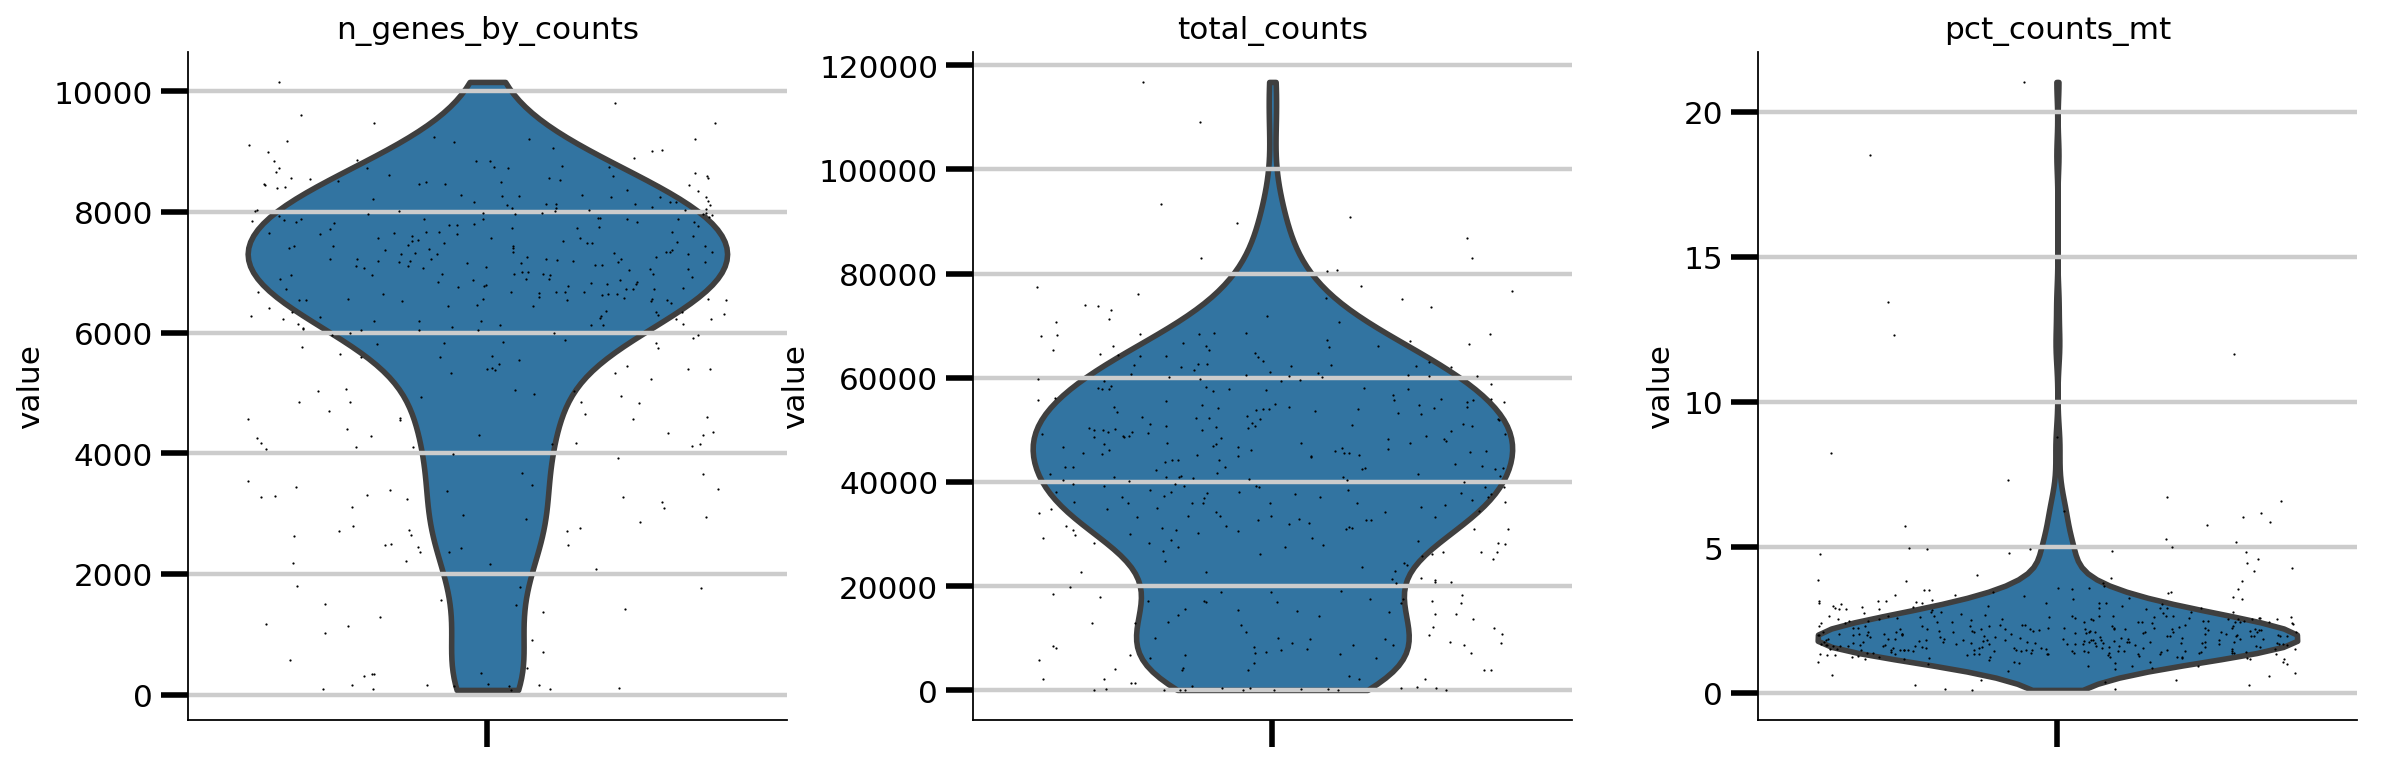

In [61]:
sc.pl.violin(sample1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

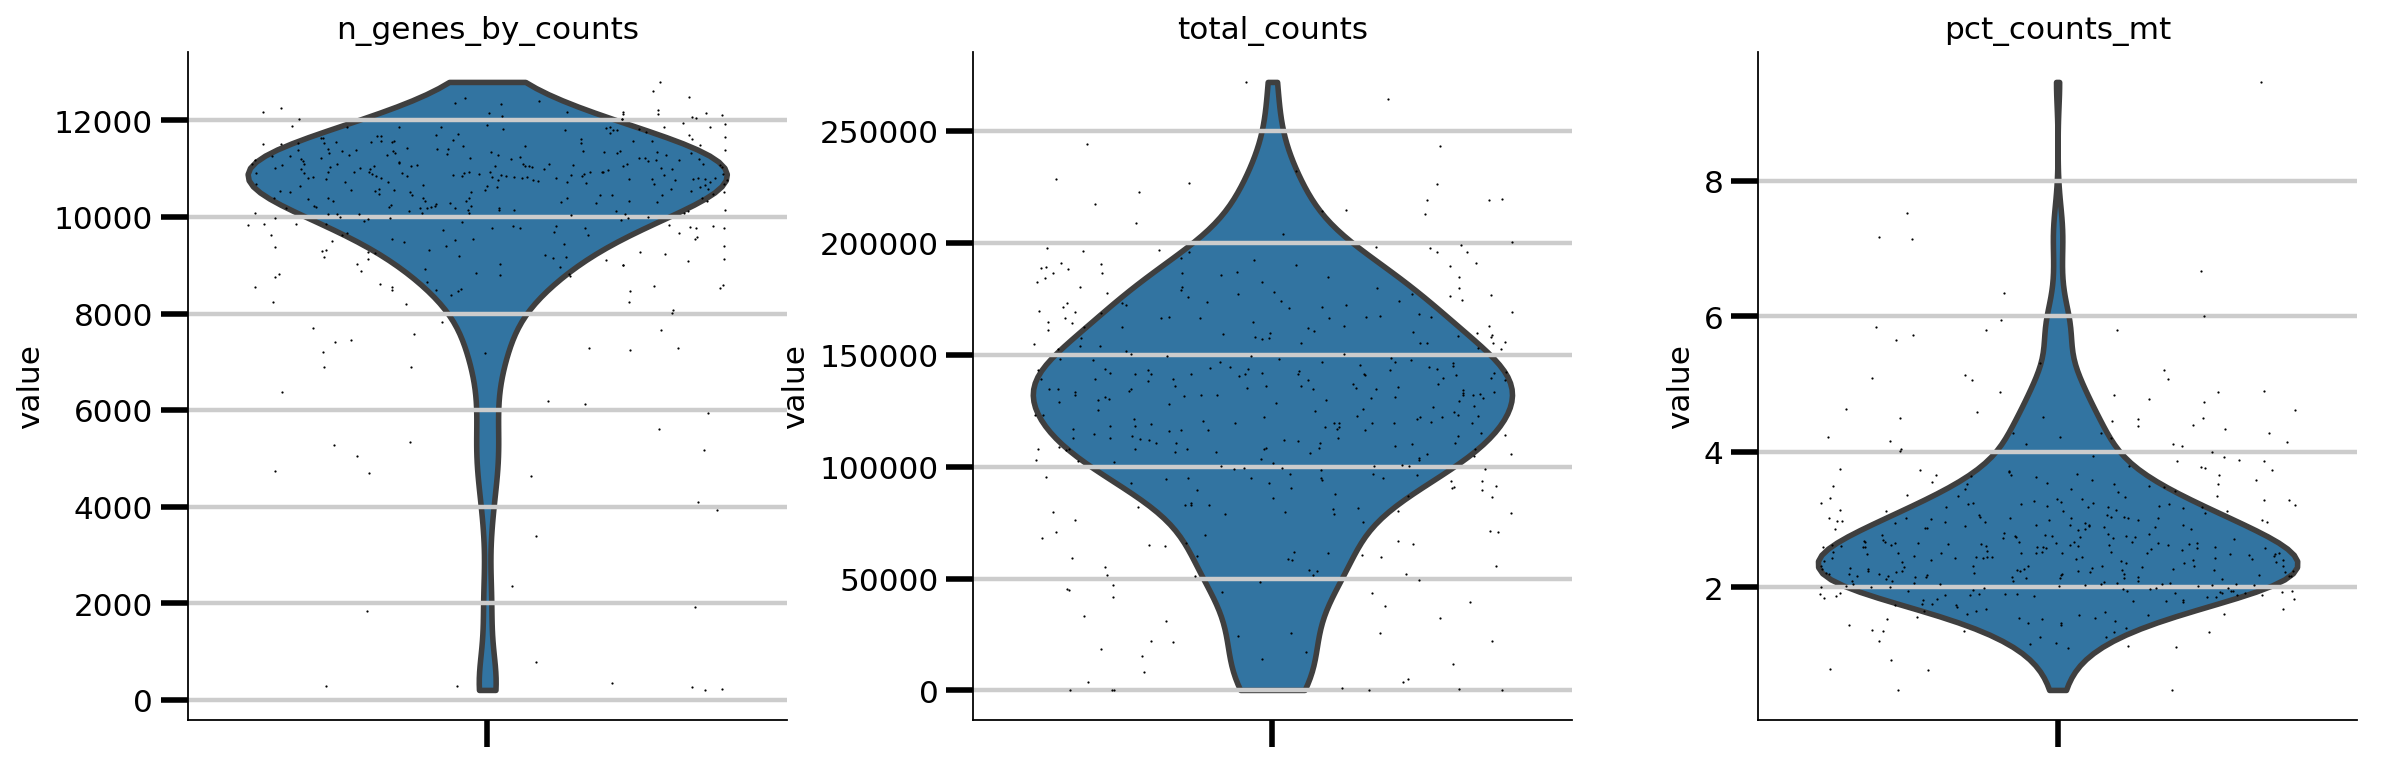

In [62]:
sc.pl.violin(sample2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

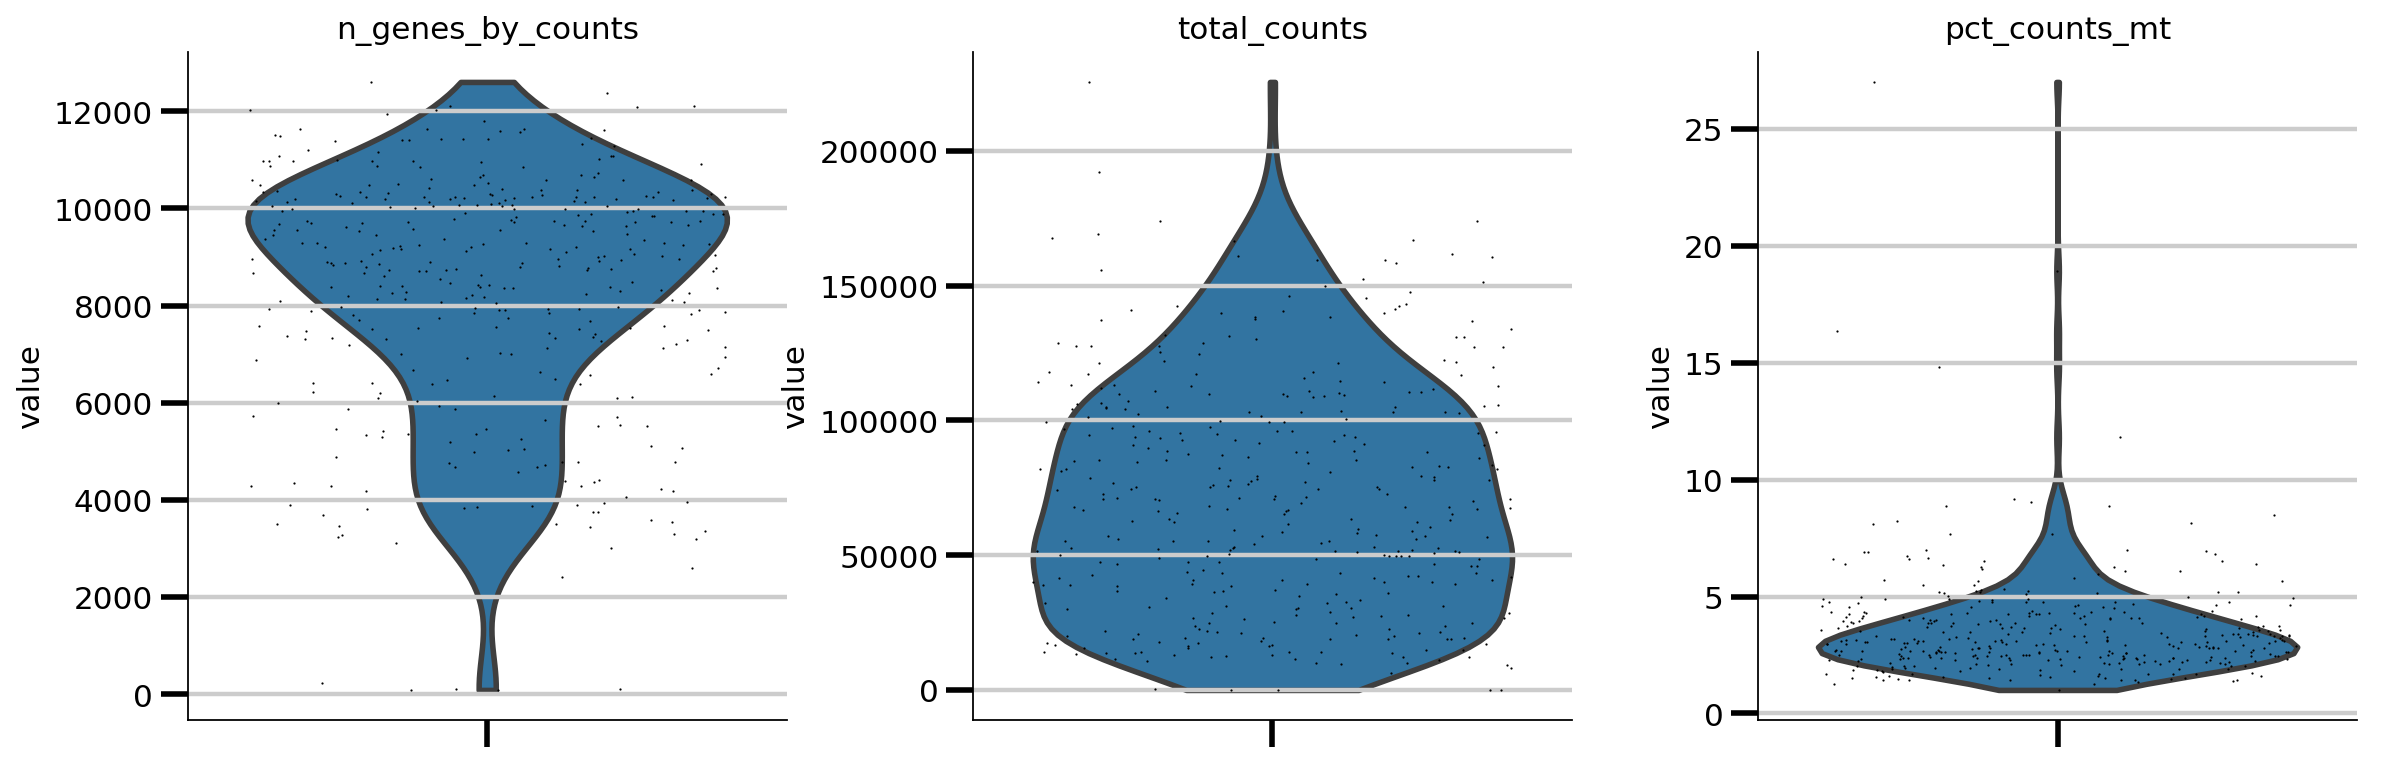

In [63]:
sc.pl.violin(sample3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

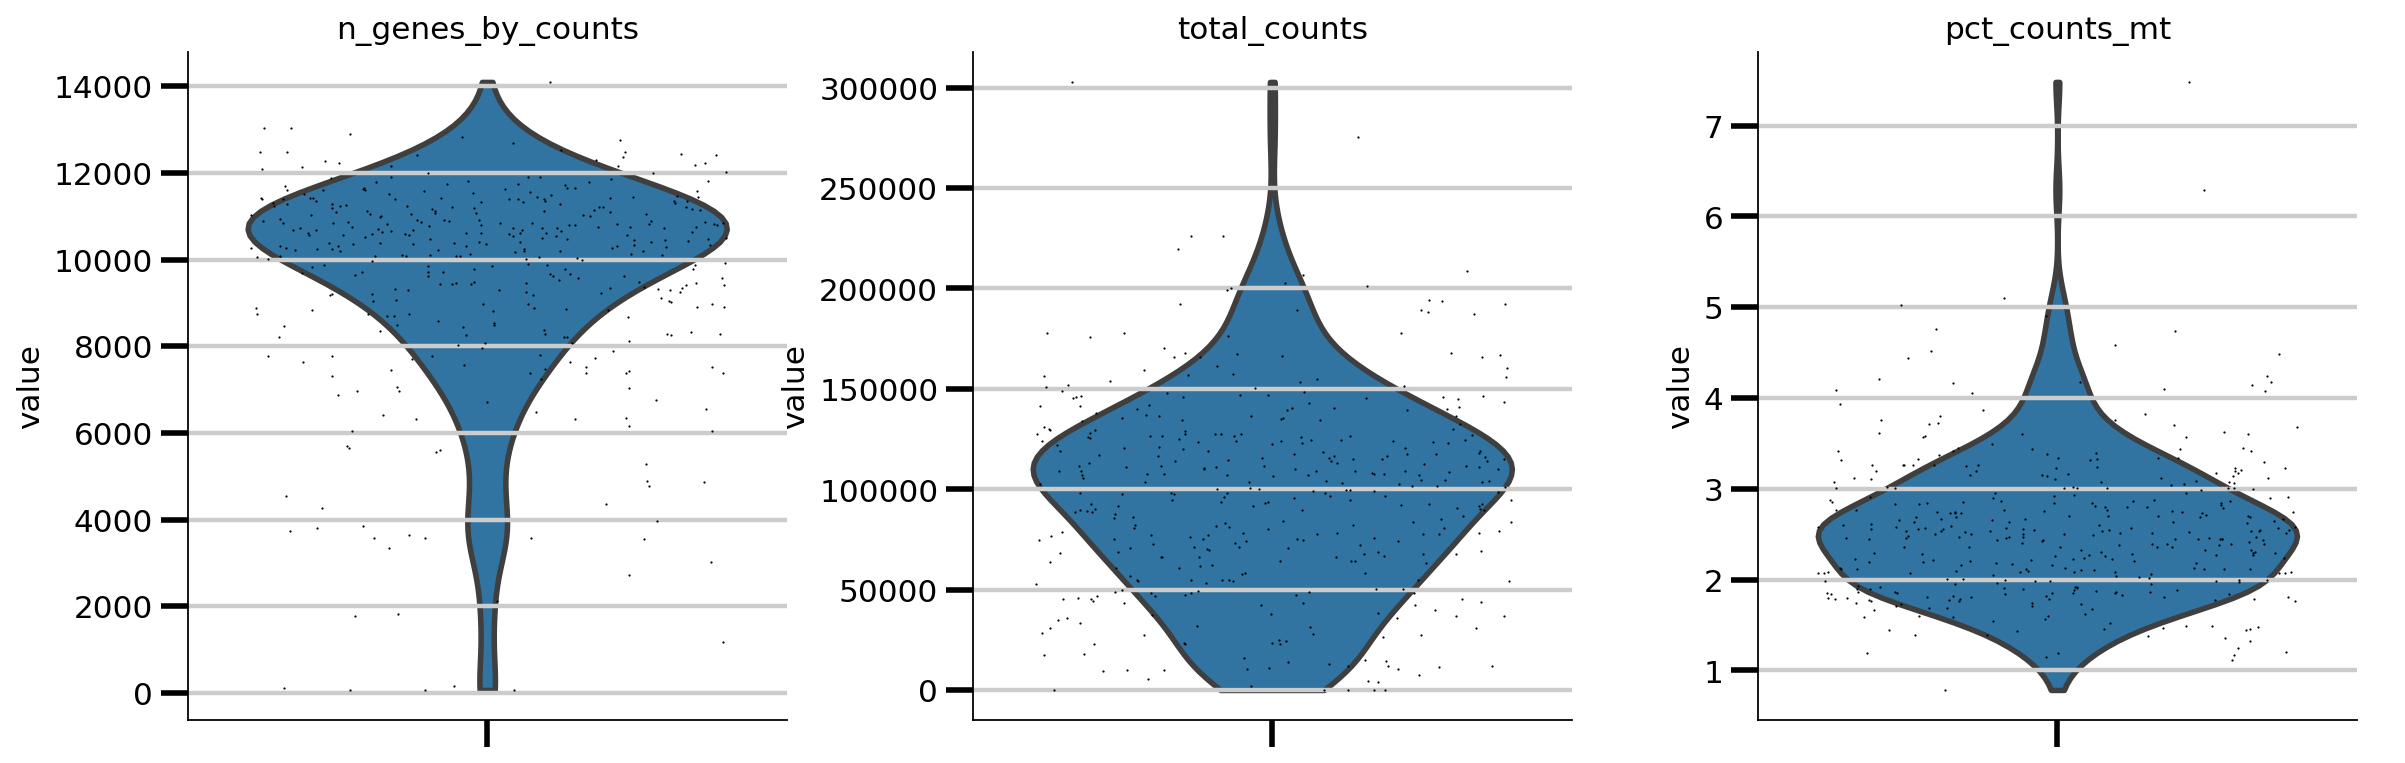

In [64]:
sc.pl.violin(sample4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

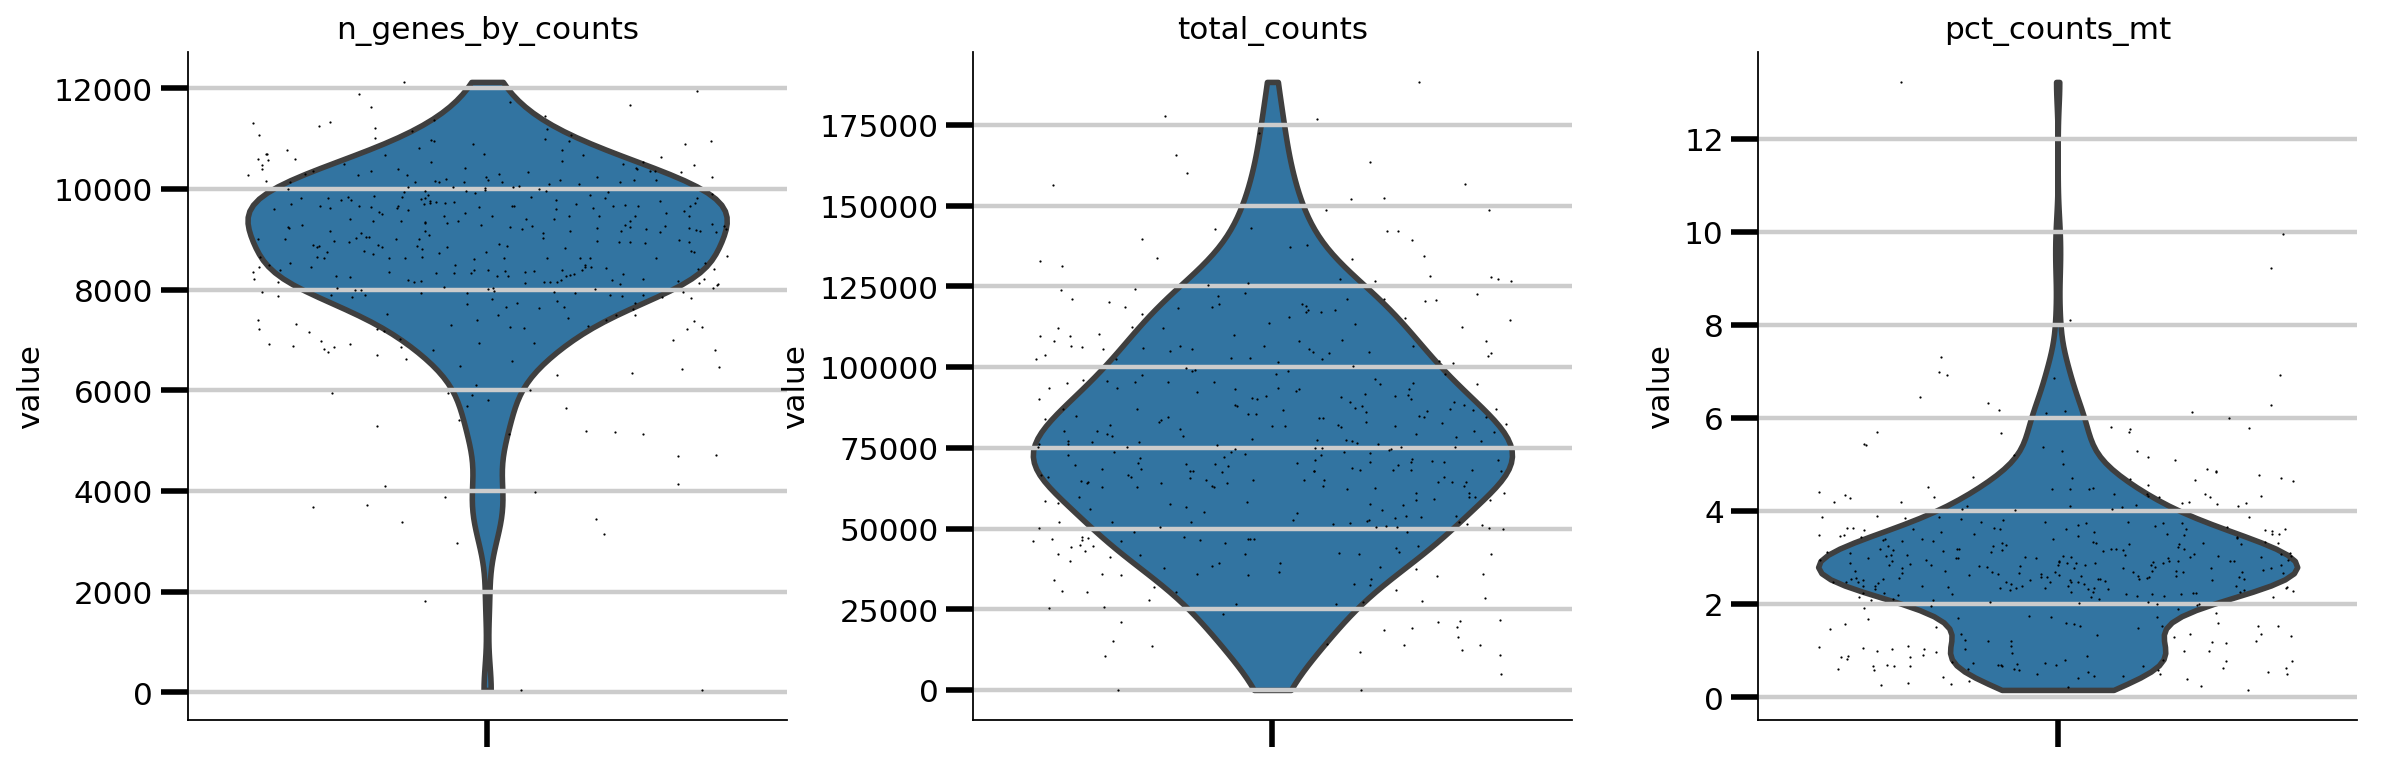

In [65]:
sc.pl.violin(sample5, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

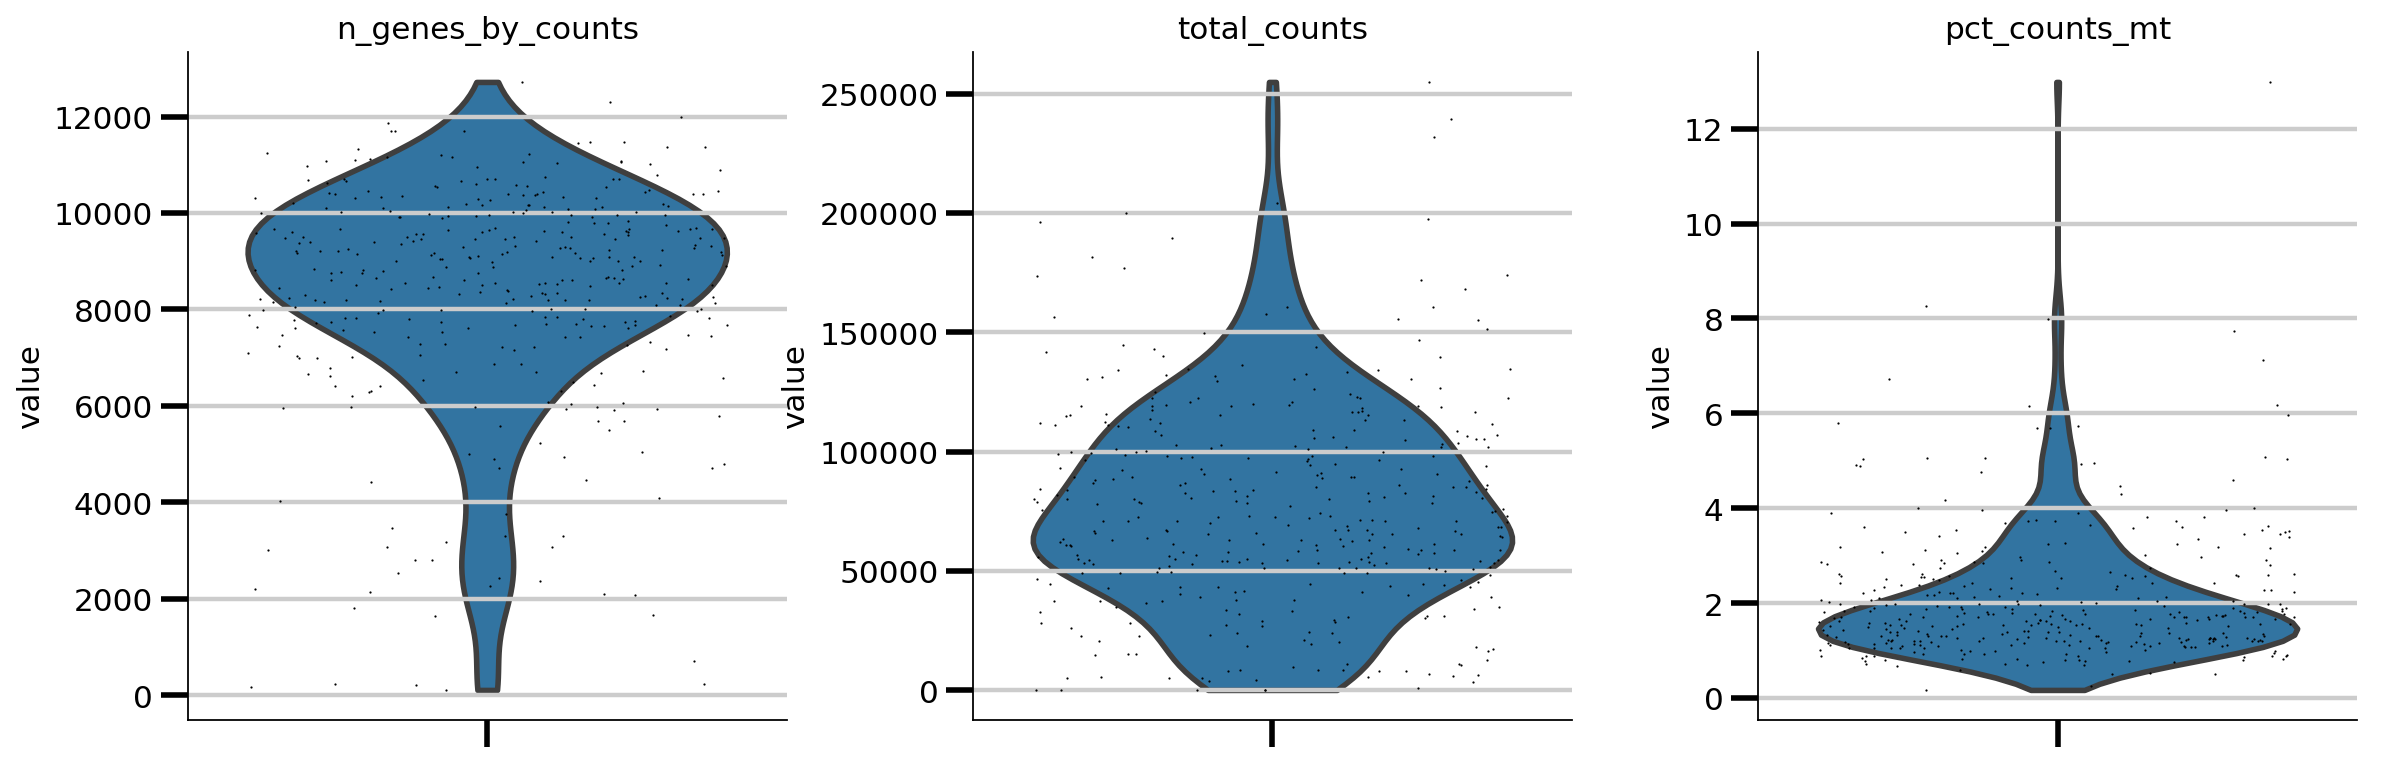

In [66]:
sc.pl.violin(sample6, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [67]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata6.n_obs))
sc.pp.filter_cells(adata6, min_counts = MIN_CELL_COUNTS)
print('Total number of cells after: {:d}'.format(adata6.n_obs))

Total number of cells before: 384
filtered out 24 cells that have less than 10000 counts
Total number of cells after: 360


In [68]:
print('Number of cells before: {:d}'.format(adata6.n_obs))
sc.pp.filter_cells(adata6, min_genes = MIN_GENES)
print('Total number of cells after: {:d}'.format(adata6.n_obs))

Number of cells before: 360
Total number of cells after: 360


In [69]:
print('Number of genes before: {:d}'.format(adata6.n_vars))
sc.pp.filter_genes(adata6, min_cells=MIN_CELLS_WITH_GENE)
print('Number of genes after: {:d}'.format(adata6.n_vars))

Number of genes before: 41321
filtered out 20080 genes that are detected in less than 5 cells


Number of genes after: 21241


In [70]:
adata6.var['mt'] = adata6.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata6, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [71]:
# Do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata6.n_obs))
# keep only below 5% mitochondrial
adata = adata6[adata6.obs.pct_counts_mt < MITOCHONDRIAL_THRESHOLD_PCT, :]
print('Number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 360
Number of cells after: 343


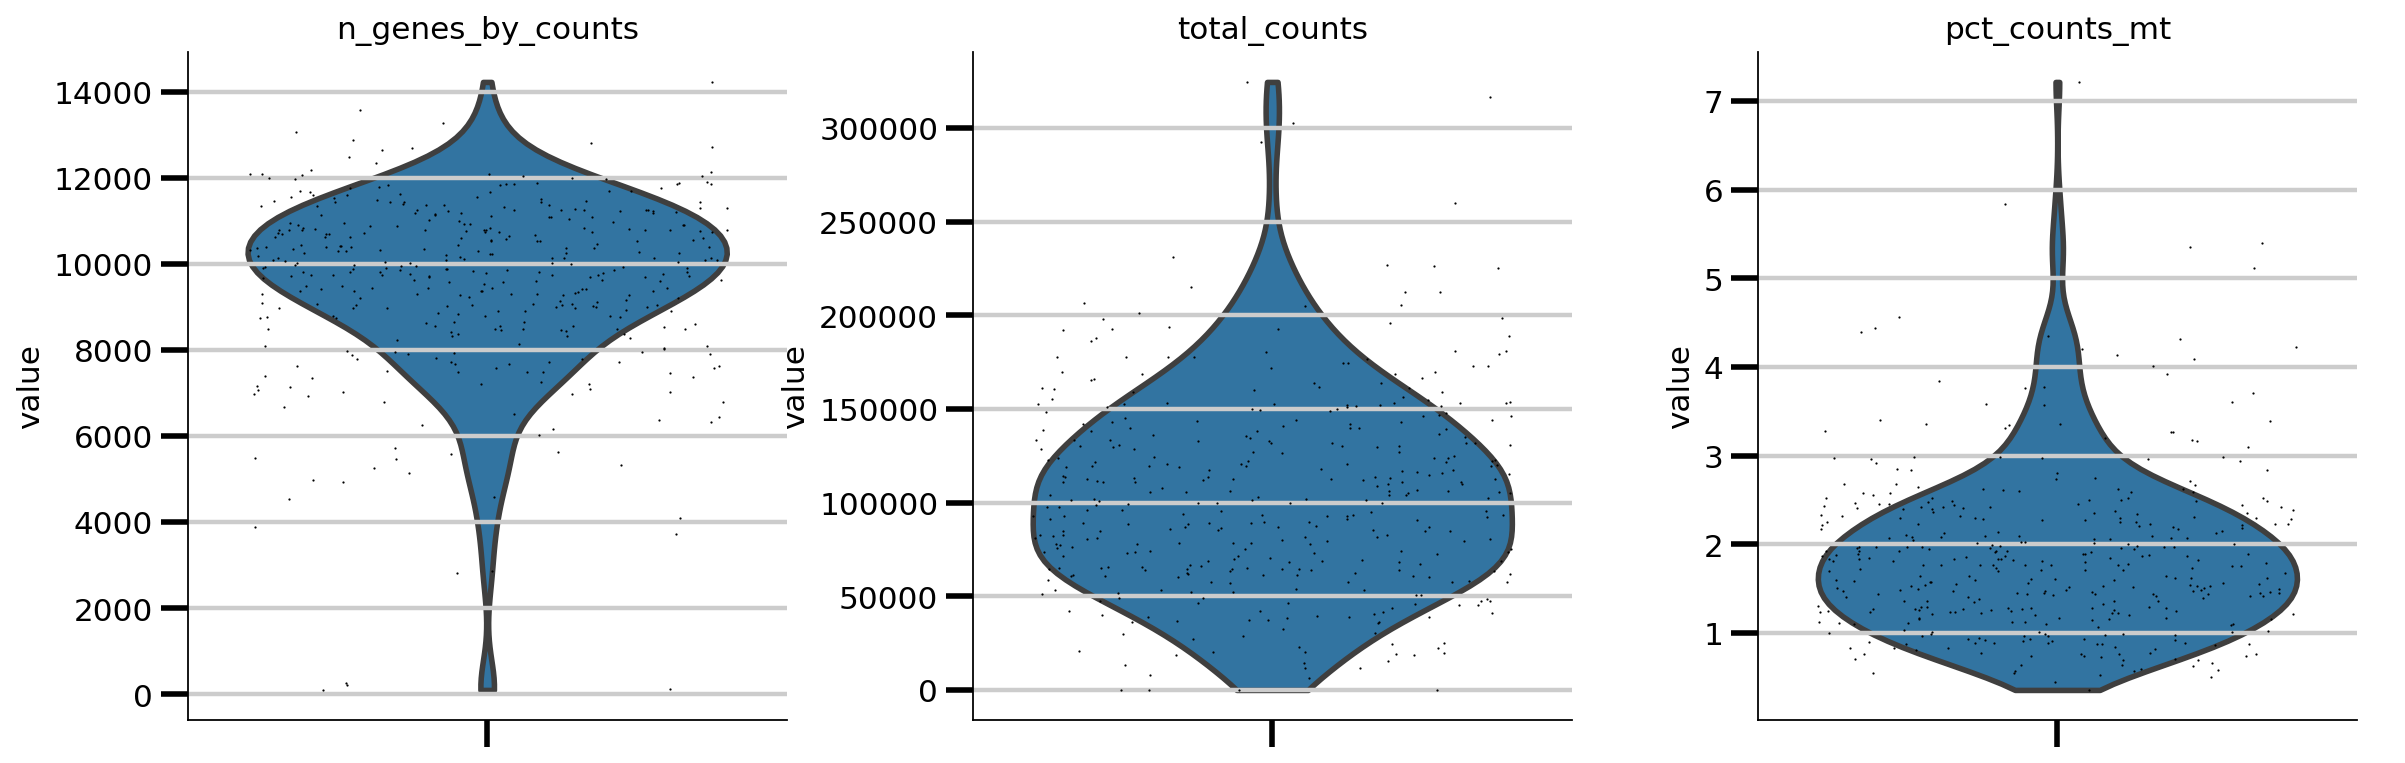

In [72]:
sc.pl.violin(sample7, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [73]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata7.n_obs))
sc.pp.filter_cells(adata7, min_counts = MIN_CELL_COUNTS)
print('Total number of cells after: {:d}'.format(adata7.n_obs))

Total number of cells before: 384
filtered out 6 cells that have less than 10000 counts


Total number of cells after: 378


In [74]:
print('Number of cells before: {:d}'.format(adata7.n_obs))
sc.pp.filter_cells(adata7, min_genes = MIN_GENES)
print('Total number of cells after: {:d}'.format(adata7.n_obs))

Number of cells before: 378
Total number of cells after: 378


In [75]:
print('Number of genes before: {:d}'.format(adata7.n_vars))
sc.pp.filter_genes(adata7, min_cells=MIN_CELLS_WITH_GENE)
print('Number of genes after: {:d}'.format(adata7.n_vars))

Number of genes before: 41321
filtered out 18655 genes that are detected in less than 5 cells


Number of genes after: 22666


In [76]:
adata7.var['mt'] = adata7.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata7, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [77]:
# Do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata7.n_obs))
# keep only below 5% mitochondrial
adata_last = adata7[adata7.obs.pct_counts_mt < MITOCHONDRIAL_THRESHOLD_PCT, :]
print('Number of cells after: {:d}'.format(adata_last.n_obs))

Number of cells before: 378
Number of cells after: 373
